<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/01_simple_supervised_learning_model_for_estimation_and_filtering_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

구현 목표 모델

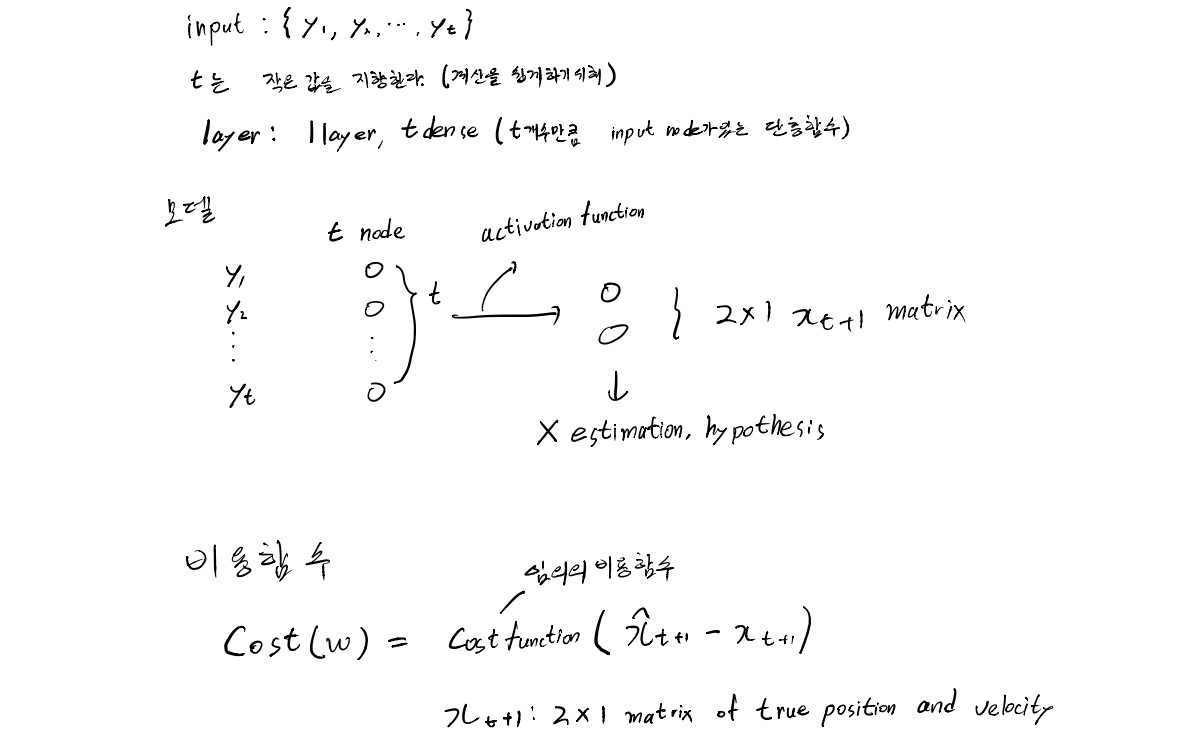

비용함수는 MSE등 임의의 비용함수 설정, Backprop방식도 임의로 설정한 뒤 학습을 진행하여 모델을 구현하는 것을 목적으로 한다. (FIR식 filtering과 같음)

데이터 생성

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(370)

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))

T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping


A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

# 1) 정규분포 노이즈

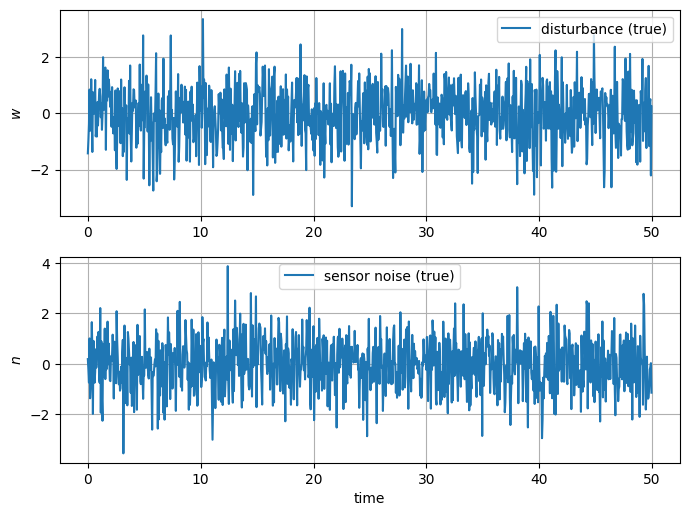

In [ ]:
w = np.random.randn(1,N)
n = np.random.randn(1,N)

w_true = w.copy()
n_true = n.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts[:-1],w_true[0,:], label='disturbance (true)')
plt.ylabel(r"$w$")
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts[:-1],n_true[0,:], label='sensor noise (true)')
plt.xlabel('time')
plt.ylabel(r'$n$')
plt.legend()
plt.grid()
plt.show()

계측값, 위치값 설정

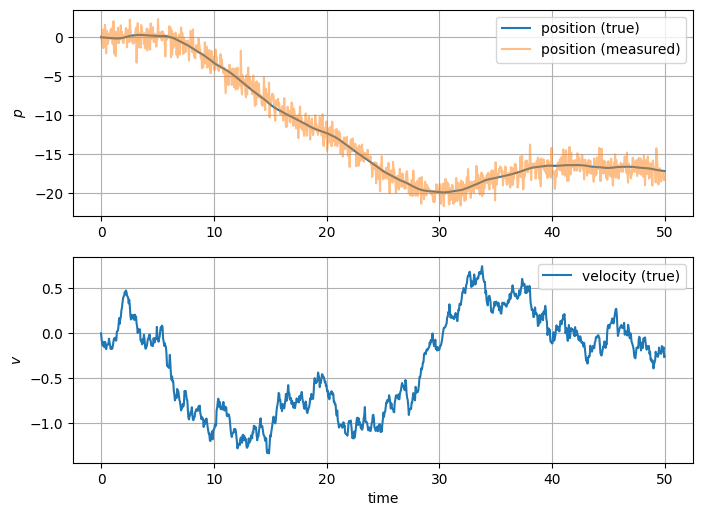

In [ ]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])

x_true = x.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(2,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

(1, 100)

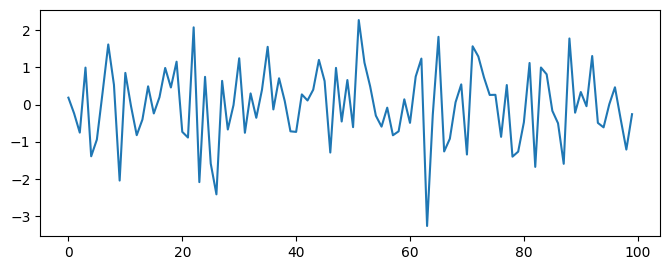

In [137]:
#학습할 데이터 사이즈 
DS = 100

train_input = np.zeros((1,DS))
#모델에 넣기 위해 채널 추가
train_input = train_input[...,tf.newaxis]
#데이터 사이즈 만큼 계측 데이터 Y를 불러옴
plt.figure(figsize=(8,3), dpi=100)
train_input = y[:,:DS].copy()
plt.plot(train_input[0,:])

filter가 될 1layer 모델 만들기

1 layer에 노드 개수는 입력값 개수와 같음

가장 기본적인 형태로 loss는 MSE, optimizer는 SGD사용

In [123]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation = 'sigmoid', input_shape = (1,DS))
  ])
  model.compile(loss='mse',
                optimizer = 'SGD',
                metrics=['accuracy'])
  return model

In [96]:
model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1, 1)              101       
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [113]:
example_result = model.predict(train_input)
example_result

array([[0.9422865]], dtype=float32)

In [134]:
train_target = np.array([x[0,DS+1]])

In [135]:
train_target

array([0.18128024])

개선이 안된다.

In [ ]:
model.fit(train_input, train_target,epochs = 10000)